<a href="https://colab.research.google.com/github/Micah-Sanders/DATS6202/blob/dev_Micah/MLtrial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, Bidirectional, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize



In [ ]:
# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Load and preprocess Lightcast data
url = 'https://github.com/Micah-Sanders/DATS6202/raw/main/Lightcast.csv' #Set URL
lightcast_data = pd.read_csv(url) #Read in file from URL
lightcast_data = lightcast_data[['DESCRIPTION', 'CATEGORY', 'SUBCATEGORY']].dropna()


In [ ]:
# Text preprocessing
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return ' '.join(tokens)

lightcast_data['DESCRIPTION'] = lightcast_data['DESCRIPTION'].astype(str).apply(preprocess_text)



In [ ]:
#  subcategory hybrids
lightcast_data['CATEGORY'] = lightcast_data['CATEGORY'].astype(str) + ' ' + lightcast_data['SUBCATEGORY'].astype(str)
lightcast_data = lightcast_data.drop('SUBCATEGORY', axis=1)


In [ ]:
# Label encoding
category_encoder = LabelEncoder()
lightcast_data['CATEGORY_encoded'] = category_encoder.fit_transform(lightcast_data['CATEGORY'])
num_categories = lightcast_data['CATEGORY_encoded'].nunique()

In [ ]:
# Splitting the dataset into train and test sets
train_data, test_data = train_test_split(lightcast_data, test_size=0.30, random_state=42)


In [ ]:
# Text vectorization
vectorizer = TextVectorization(max_tokens=10000, output_sequence_length=100)
text_ds = tf.data.Dataset.from_tensor_slices(train_data['DESCRIPTION']).batch(128)
vectorizer.adapt(text_ds)

In [ ]:
# Preparing dataset for training
train_ds = tf.data.Dataset.from_tensor_slices((train_data['DESCRIPTION'], train_data['CATEGORY_encoded'])).batch(128)
val_ds = tf.data.Dataset.from_tensor_slices((test_data['DESCRIPTION'], test_data['CATEGORY_encoded'])).batch(128)


In [ ]:
# Model definition
model = Sequential([
    vectorizer,
    Embedding(10000, 128, mask_zero=True),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(128)),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_categories, activation='softmax', name='category_output')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 100)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 100, 128)          1280000   
                                                                 
 bidirectional (Bidirection  (None, 100, 256)          263168    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 100, 256)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                        

Epoch 1/50
47/47 [==============================] - 103s 2s/step - loss: 1.8626 - accuracy: 0.5349 - val_loss: 4.1114 - val_accuracy: 0.3038
Epoch 2/50
47/47 [==============================] - 114s 2s/step - loss: 1.6737 - accuracy: 0.5655 - val_loss: 4.3367 - val_accuracy: 0.3244
Epoch 3/50
47/47 [==============================] - 109s 2s/step - loss: 1.5338 - accuracy: 0.6042 - val_loss: 4.5201 - val_accuracy: 0.2995
Epoch 4/50
47/47 [==============================] - 110s 2s/step - loss: 1.4185 - accuracy: 0.6319 - val_loss: 5.2934 - val_accuracy: 0.3299


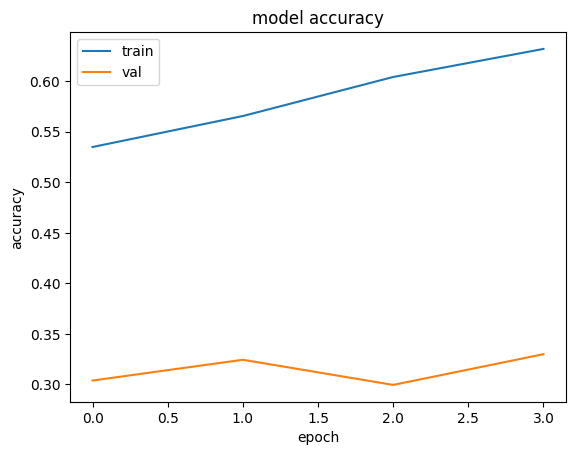

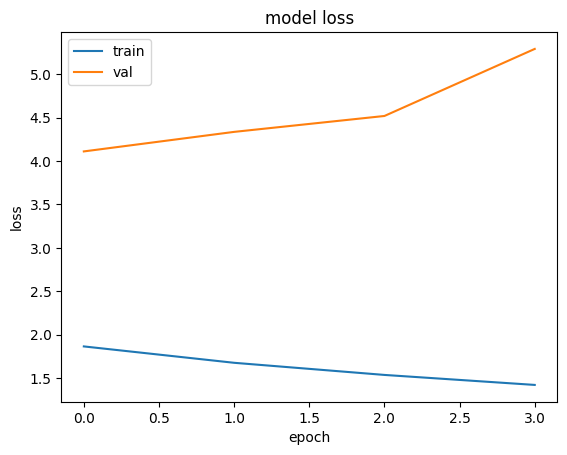

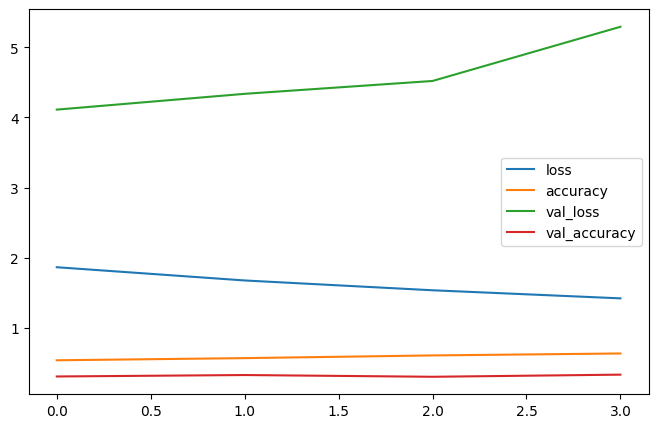

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=[early_stopping])

# Plot Accuracy vs. val_accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot Loss vs. val_loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot All
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()


In [ ]:
# Evaluate the model on the test set
test_results = model.evaluate(val_ds)
print(f"Test Accuracy: {test_results[1]*100:.2f}%")

20/20 [==============================] - 12s 569ms/step - loss: 4.1114 - accuracy: 0.3038
Test Accuracy: 30.38%
